## Westeros electrified - intoducing a MEDIUM C02 cap

This notebook creates a bound on the emissions by introducing a energy mix constraing. 30% of the energy has to be generated from renewables sources.

By Maja Heim

In [43]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

In [44]:
mp = ixmp.Platform()

## Adding a MEDIUM Bound on Emissions

In [45]:
## cloning the baseline scenario
model = "Westeros Electrified"
base = message_ix.Scenario(mp, model=model, scenario="baseline")
scen_med = base.clone(
    model,
    "generation_constraint",
    "constraint on energy generation from fossil sources",
    keep_solution=False,
)
scen_med.check_out()

year_df = scen_med.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen_med.set("year")
country = "Westeros"



#### Adding the constraint

We will be adding a share constraint, which aimed at limiting the activity of a single or set of technologies to a certain share of the activity of another single or set of technologies. In this scenario we will introduce a constraint stating that at least 30% of the energy mix has to come from renewable sources (in this case wind). This should be accomplished by 720.

##### 1. Defining a new share

In [46]:
shares = "share_renewable_electricity"
scen_med.add_set("shares", shares)

##### 2. Defining technologies that make up total energy generation
In this scenario, wind and coal contribute. They are grouped as a new `type_tec`, called `"electricity_total"`.

In [47]:
type_tec = "electricity_total"
scen_med.add_cat("technology", type_tec, "wind_ppl")
scen_med.add_cat("technology", type_tec, "coal_ppl")

scen_med.idx_names("map_shares_commodity_total")

# Adding the data frame to a set using the inedx name defined above
df = pd.DataFrame(
    {
        "shares": [shares],
        "node_share": country,
        "node": country,
        "type_tec": type_tec,
        "mode": "standard",
        "commodity": "electricity",
        "level": "secondary",
    }
)
scen_med.add_set("map_shares_commodity_total", df)

##### 3. Defining technologies that fulfill our share
`wind_ppl` will be providing 30% of the electricity

In [48]:
# only wind is added to tpye_tec renewable
type_tec = "electricity_renewable"
scen_med.add_cat("technology", type_tec, "wind_ppl")

# add this to data frame
df = pd.DataFrame(
    {
        "shares": [shares],
        "node_share": country,
        "node": country,
        "type_tec": type_tec,
        "mode": "standard",
        "commodity": "electricity",
        "level": "secondary",
    }
)
scen_med.add_set("map_shares_commodity_share", df)

##### 4. Defining our share
Acutal share value is added to the model. For this scenario the constraint should act as a lower bound.

In [49]:
# Fetching the index names of a parameter
scen_med.idx_names("share_commodity_lo")

# Adding data to the parameter
df = pd.DataFrame(
    {
        "shares": shares,
        "node_share": country,
        "year_act": [720],
        "time": "year",
        "value": [0.3],
        "unit": "-",
    }
)
scen_med.add_par("share_commodity_lo", df)

In [50]:
# Commit and Solve Model
scen_med.commit(comment="Define parameters for max. renewable share constraint")
scen_med.set_as_default()
scen_med.solve()
scen_med.var("OBJ")["lvl"]

204093.984375

#### Plotting results

In [51]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

# Scenario without share constraint
base_rep = Reporter.from_scenario(base)
prepare_plots(base_rep)

# Scenario with share constraint
rep = Reporter.from_scenario(scen_med)
prepare_plots(rep)



### Activity
--> The amount of energy that is generated in each time period from the different potential sources.

Below we can see both the activity of the baseline and the scenario with the medium bound. By 720, just as intended, 30% of the electricity is generated from wind. `wind_ppl` has a diffusion rate of about 10%, therefore the activity is ramped up each year until it reaches about 30% in 720.

<Axes: title={'center': 'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

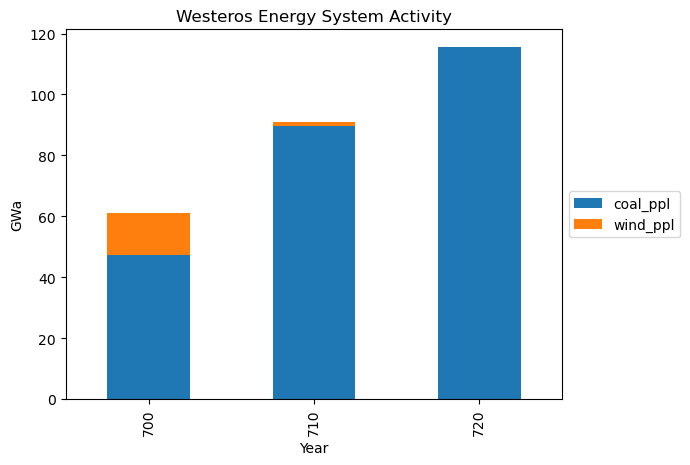

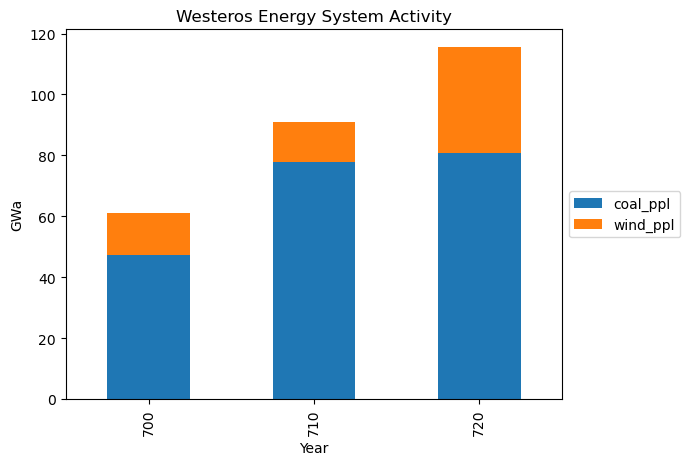

In [52]:
plants = ["coal_ppl", "wind_ppl"]
base_rep.set_filters(t=plants)
base_rep.get("plot activity")

rep.set_filters(t=plants)
rep.get("plot activity")

### Capacity
--> The amount of capacity of each plant that is installed

The increase in wind activity (seen above) is reflected here in the capacity. Especailly in 720 we can see, that the wind capacity is very high, which results in the 30% of wind activity.

<Axes: title={'center': 'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

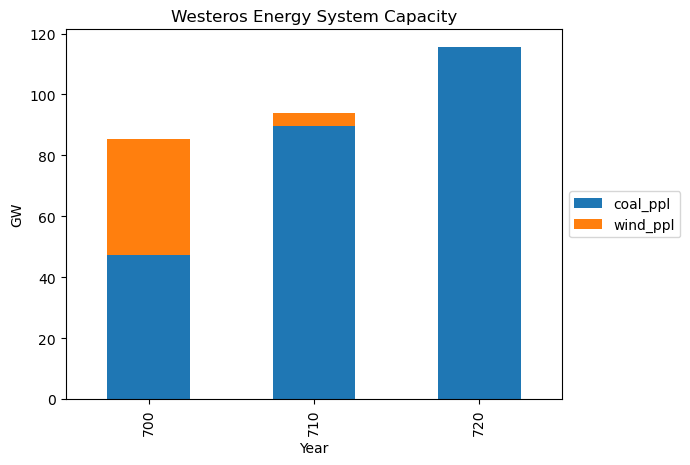

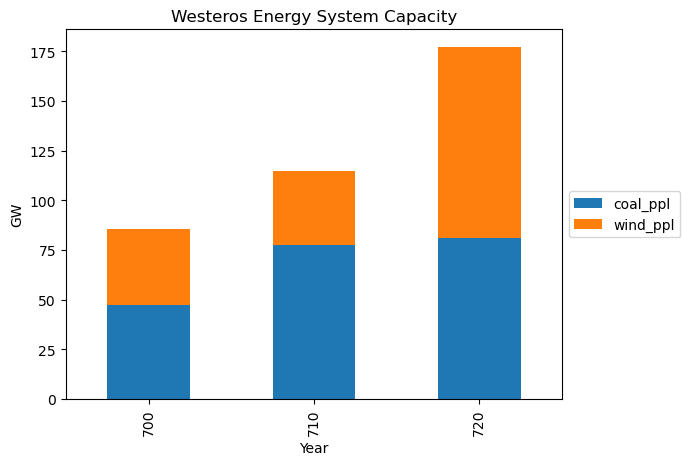

In [53]:
base_rep.get("plot capacity")
rep.get("plot capacity")

### Electricity Price
--> The price of electricity

The increase of the wind activity is also reflected in the electricity's price in 720.

<Axes: title={'center': 'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

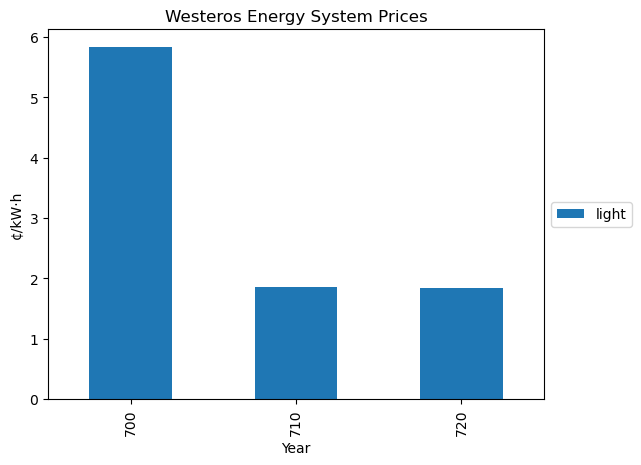

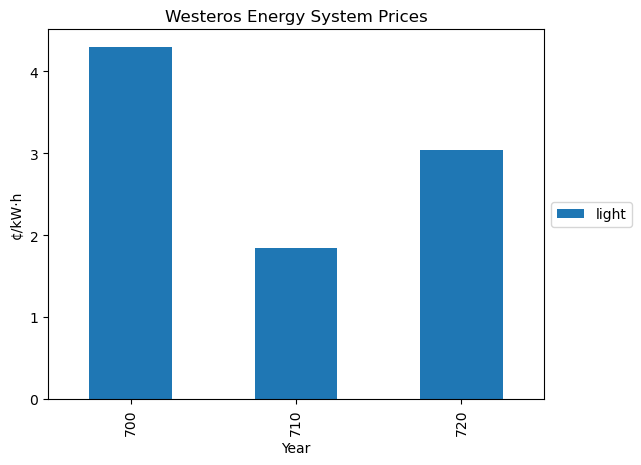

In [54]:
filters = dict(t=None, c=["light"])
base_rep.set_filters(**filters)
base_rep.get("plot prices")

rep.set_filters(**filters)
rep.get("plot prices")

## Close the connection to the database

In [55]:
mp.close_db()